In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb
from pyearth import Earth

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
y_train = train.y
train = train.drop(columns=['y', 'id'])

In [3]:
train.head()

,x001,x002,x003,x004,x005,x006,x007,x008,x009,x010,...,x756,x757,x758,x759,x760,x761,x762,x763,x764,x765
0,9.681860e+10,6991.15,7.76,0.00380,5.378811e+09,0.31,266117.20,934577.0,14539.0,26900000000000,...,1.5707,0.0007,297281012,0.13,5.0,5,2.0,8.5127,14.28,-0.75
1,3.304810e+09,13914.43,5.37,0.00015,1.652405e+09,0.00,11927742.92,1798051.0,1051272.0,169000000000000000,...,0.1173,0.1136,3320000000000,0.08,661.0,0,350.0,1.5700,160.12,NaN
2,3.218944e+10,3991.98,5.77,0.00010,2.476111e+09,0.00,774385.01,375738.0,144143.0,135000000000000,...,0.4582,0.0029,100474819,0.39,39.0,2,18.0,9.6800,25.06,-0.49
3,1.288000e+10,15937.45,5.86,0.00020,2.146667e+09,0.00,6324375.16,1932094.0,10055.0,37000000000000000,...,0.3816,0.0000,348000000000,0.25,2.0,1,0.0,4.5316,117.76,1.64
4,3.063412e+10,3621.00,7.52,0.00060,1.392460e+09,0.21,169860.29,474253.0,17914.0,6000000000000,...,0.0100,0.0005,109546590,0.11,11.0,1,3.0,16.2717,5.81,-0.42


### EDA

In [4]:
cor_lst = np.abs(train.corrwith(y_train)).sort_values(ascending=False)
cor_lst

x146    0.378696
x102    0.378436
x014    0.364737
x581    0.346549
x619    0.344101
          ...   
x465         NaN
x518         NaN
x594         NaN
x643         NaN
x703         NaN
Length: 754, dtype: float64

In [5]:
cor_lst[cor_lst.isna()]

x063   NaN
x137   NaN
x255   NaN
x385   NaN
x405   NaN
x453   NaN
x465   NaN
x518   NaN
x594   NaN
x643   NaN
x703   NaN
dtype: float64

In [6]:
train.shape

(5380, 765)

In [7]:
y_train.shape

(5380,)

we see some of the values in the corr list are NaN - why?

In [8]:
train.x063.value_counts()

0    5380
Name: x063, dtype: int64

In [9]:
train.x137.value_counts()

0    5380
Name: x137, dtype: int64

only value = 0 so that will not help us with our prediction

In [10]:
nan_preds = cor_lst[cor_lst.isna()]
nan_preds = nan_preds.index
X = train.drop(columns=nan_preds)

In [11]:
X.shape

(5380, 754)

recalculate the corr list

In [12]:
cor_lst = np.abs(X.corrwith(y_train)).sort_values(ascending=False)
cor_lst

x146    0.378696
x102    0.378436
x014    0.364737
x581    0.346549
x619    0.344101
          ...   
x681    0.001357
x132    0.001202
x536    0.000868
x054    0.000863
x376    0.000454
Length: 743, dtype: float64

In [13]:
X.shape

(5380, 754)

looking more into the top 10 more correlated 

In [14]:
top_10 = cor_lst[:10].index


In [15]:
top_10

Index(['x146', 'x102', 'x014', 'x581', 'x619', 'x687', 'x651', 'x696', 'x755',
       'x096'],
      dtype='object')

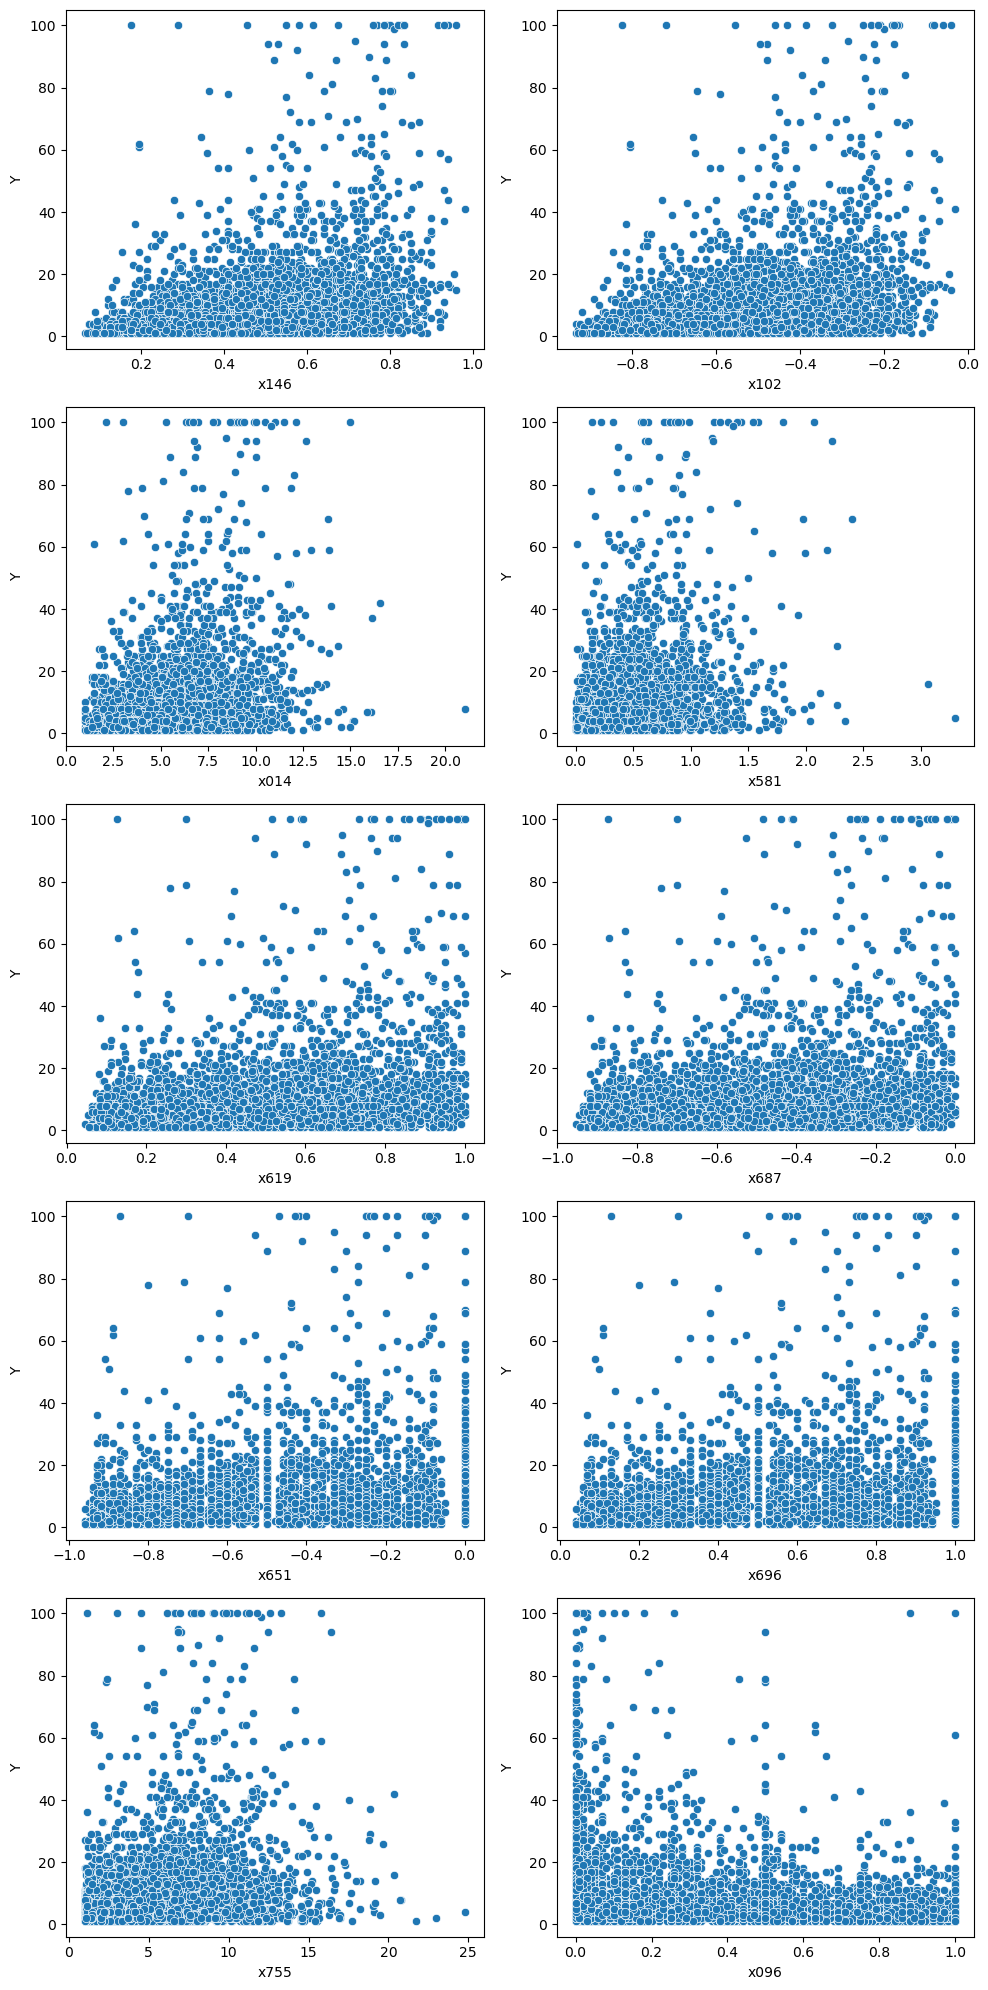

In [16]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))
for i, ax in enumerate(axs.flatten()):
    x = top_10[i]
    sns.scatterplot(x=X[x], y=y_train, ax=ax)
    ax.set_xlabel(f"{top_10[i]}")
    ax.set_ylabel("Y")

plt.tight_layout()
plt.show()

also look at outliers

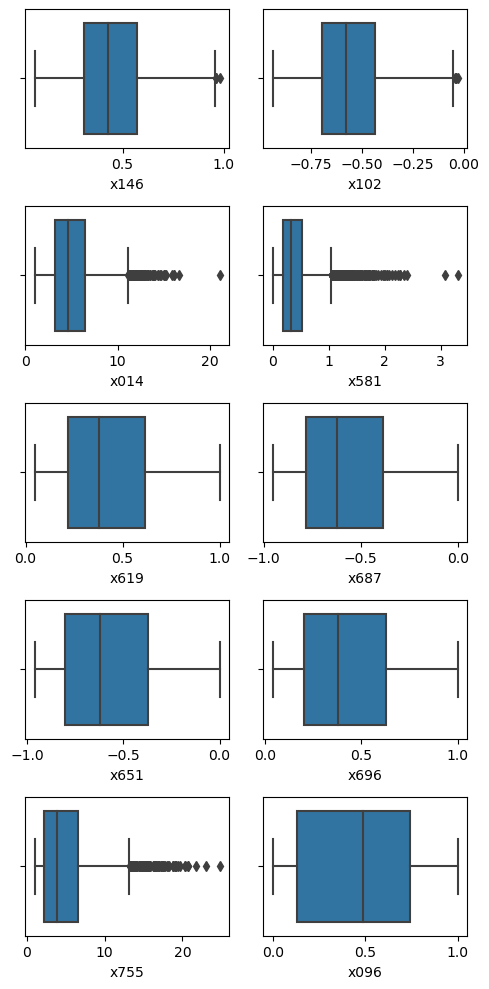

In [17]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(5, 10))
for i, ax in enumerate(axs.flatten()):
    x = top_10[i]
    sns.boxplot(x=X[x], ax=ax)
    ax.set_xlabel(f"{top_10[i]}")

plt.tight_layout()
plt.show()

look at output of y to see if transformation is appropriate 

In [18]:
y_train_original = y_train.copy()

<AxesSubplot:xlabel='y', ylabel='Density'>

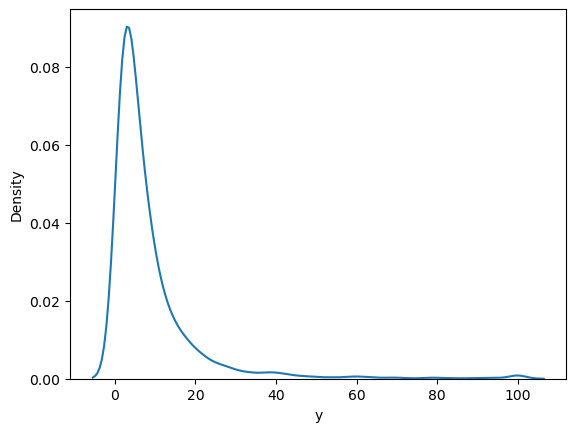

In [19]:
sns.kdeplot(data=y_train)

<AxesSubplot:xlabel='y', ylabel='Density'>

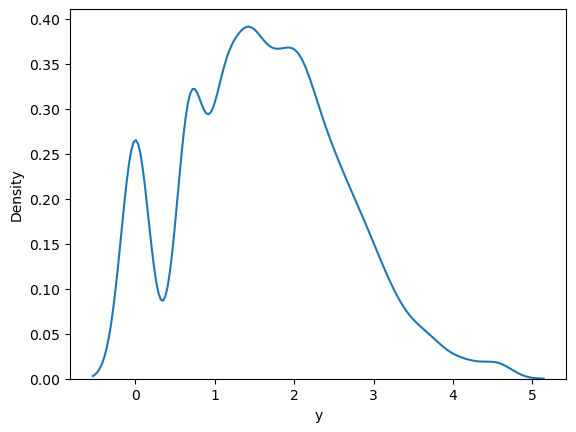

In [20]:
sns.kdeplot(data=np.log(y_train))

other possible transformations

<AxesSubplot:xlabel='y', ylabel='Density'>

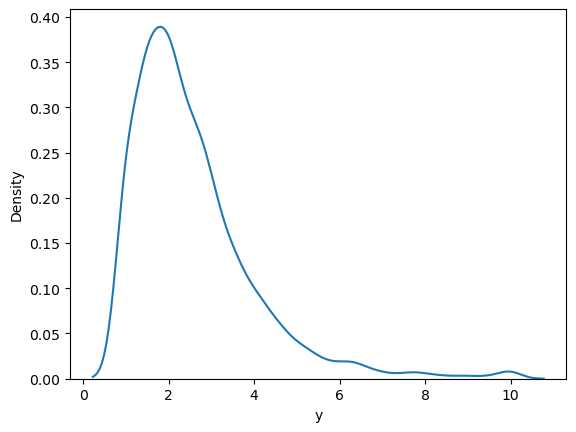

In [21]:
sns.kdeplot(data=np.sqrt(y_train))

In [22]:
y_train = np.log(y_train_original)

<AxesSubplot:xlabel='y', ylabel='Density'>

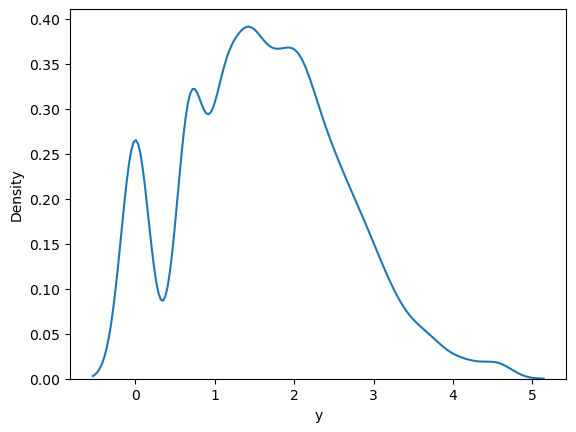

In [23]:
sns.kdeplot(data=y_train)

In [24]:
y_train.shape

(5380,)

In [25]:
y_train.value_counts()

0.693147    720
0.000000    640
1.098612    604
1.386294    570
1.609438    390
           ... 
4.418841      1
4.248495      1
4.343805      1
4.262680      1
4.219508      1
Name: y, Length: 81, dtype: int64

binning?

In [26]:
bins, counts = pd.cut(y_train, 2, retbins=True)
counts = np.array(counts)
print(bins.value_counts())

(-0.00461, 2.303]    4163
(2.303, 4.605]       1217
Name: y, dtype: int64


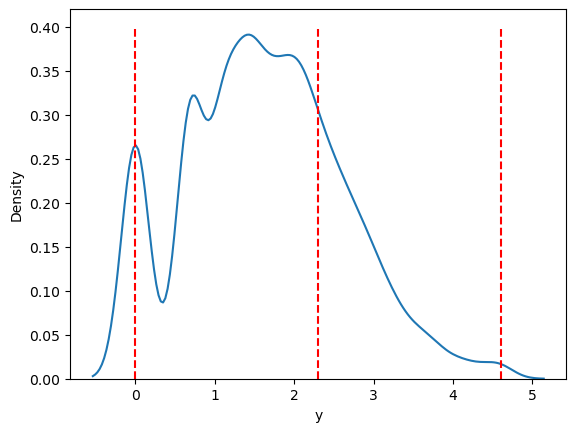

In [27]:
# Plot density plot
sns.kdeplot(y_train)
plt.vlines(x=counts, ymin=0, ymax=.4, colors='red', linestyles='--')
# plt.xlabel('Values')
# plt.ylabel('Density')
plt.show()

# # Plot vertical lines at bin cuts
# for bin_edge in bins.cat.categories:
#     plt.axvline(x=bin_edge.right, color='red', linestyle='--')

In [28]:
min(y_train)

0.0

not sure binning is the answer - seems like my best best is the np.sqrt

In [29]:
y_train = np.sqrt(y_train_original)

## now lets look into tuning hyperparameters

In [30]:
y_train.shape

(5380,)

In [31]:
X.shape

(5380, 754)

In [32]:
top_pred_X = X.loc[:,top_10]

In [33]:
top_pred_X.shape

(5380, 10)

In [34]:
# Get the length of each column
col_lengths = top_pred_X.apply(lambda x: len(x))
print(col_lengths)

x146    5380
x102    5380
x014    5380
x581    5380
x619    5380
x687    5380
x651    5380
x696    5380
x755    5380
x096    5380
dtype: int64


In [35]:
# drop NaNs from NumPy array
no_nans = ~np.isnan(top_pred_X).any(axis=1)
print("cols:\n", no_nans[~no_nans]) # dropped cols
X_no_nans = top_pred_X[no_nans]
y_train = y_train[no_nans]

cols:
 798     False
4115    False
dtype: bool


In [36]:
X_no_nans.shape

(5378, 10)

In [37]:
y_train.shape

(5378,)

In [38]:
y = y_train
# practice data
X_train, X_test, y_train, y_test = train_test_split(X_no_nans, y, test_size=0.2, random_state=1)

n estimators v cross validation error

In [39]:
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [5, 10, 50, 100, 500, 1000, 2000, 5000]
    for n in n_trees:
        models[str(n)] = xgb.XGBRegressor(n_estimators=n,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

>5 1.353 (0.056)
>10 1.315 (0.044)
>50 1.376 (0.042)
>100 1.416 (0.043)
>500 1.467 (0.045)


>4 1.404 (0.060)
>6 1.330 (0.054)
>8 1.315 (0.046)
>10 1.315 (0.044)
>12 1.320 (0.042)
>14 1.322 (0.041)
>16 1.327 (0.043)
>18 1.330 (0.042)
>20 1.333 (0.043)
>22 1.338 (0.045)
>24 1.341 (0.045)
>26 1.344 (0.045)
>28 1.346 (0.042)
>30 1.347 (0.043)


Text(0.5, 0, 'Number of trees')

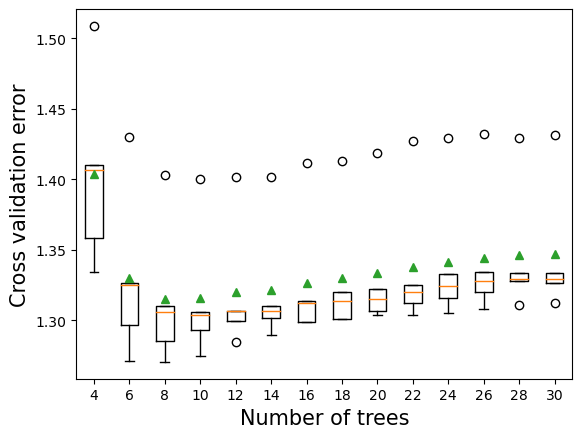

In [ ]:
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
    for n in n_trees:
        models[str(n)] = xgb.XGBRegressor(n_estimators=n,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

>1 1.270 (0.058)
>2 1.289 (0.059)
>3 1.320 (0.047)
>4 1.353 (0.046)
>5 1.379 (0.064)
>6 1.393 (0.048)
>7 1.411 (0.059)
>8 1.433 (0.054)
>9 1.436 (0.064)
>10 1.424 (0.054)
>11 1.433 (0.048)
>12 1.438 (0.065)
>13 1.441 (0.058)
>14 1.442 (0.052)
>15 1.432 (0.068)
>16 1.432 (0.045)
>17 1.434 (0.063)
>18 1.438 (0.058)
>19 1.438 (0.058)
>20 1.441 (0.059)


Text(0.5, 0, 'Depth of each tree')

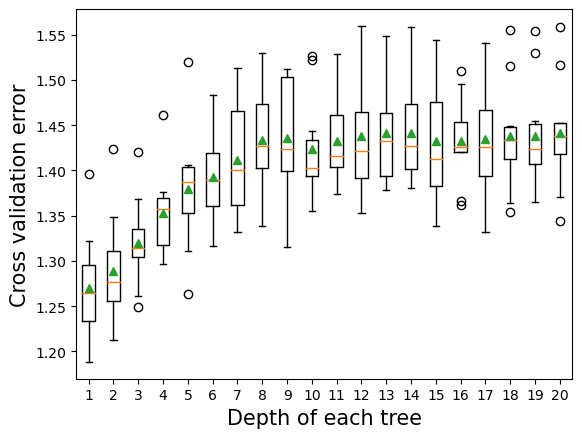

In [ ]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # explore depths from 1 to 10
    for i in range(1,21):
        # define ensemble model
        models[str(i)] = xgb.XGBRegressor(random_state=1,max_depth=i)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

>0.0100 1.5 (0.1)
>0.0500 1.3 (0.1)
>0.1000 1.3 (0.1)
>0.2000 1.4 (0.1)
>0.3000 1.4 (0.0)
>0.4000 1.4 (0.1)
>0.5000 1.5 (0.1)
>0.6000 1.5 (0.1)
>0.8000 1.6 (0.1)
>1.0000 1.7 (0.1)


Text(0.5, 0, 'Learning rate')

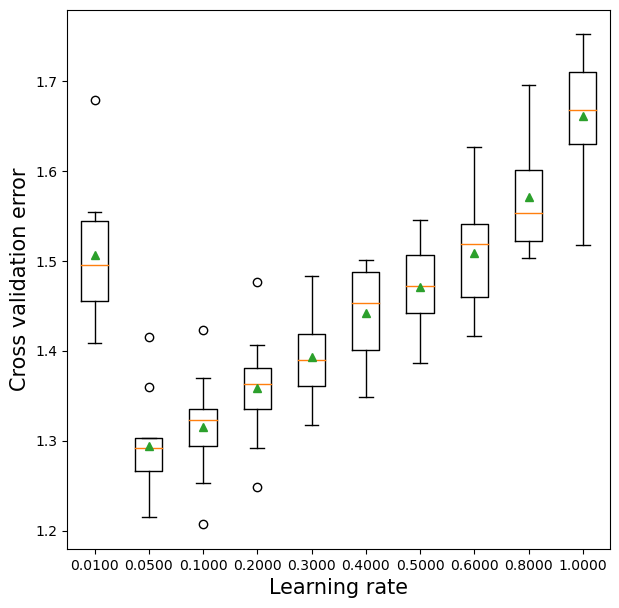

In [ ]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1.0]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(learning_rate=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

>0.0000 1.4 (0.1)
>0.5000 1.4 (0.1)
>1.0000 1.4 (0.0)
>1.5000 1.4 (0.0)
>2.0000 1.4 (0.1)
>10.0000 1.4 (0.0)
>100.0000 1.3 (0.1)
>200.0000 1.3 (0.1)
>300.0000 1.3 (0.1)
>400.0000 1.3 (0.1)
>500.0000 1.3 (0.1)
>600.0000 1.3 (0.1)
>700.0000 1.3 (0.1)
>800.0000 1.3 (0.1)
>900.0000 1.3 (0.1)
>1000.0000 1.3 (0.1)


Text(0.5, 0, 'reg_lambda')

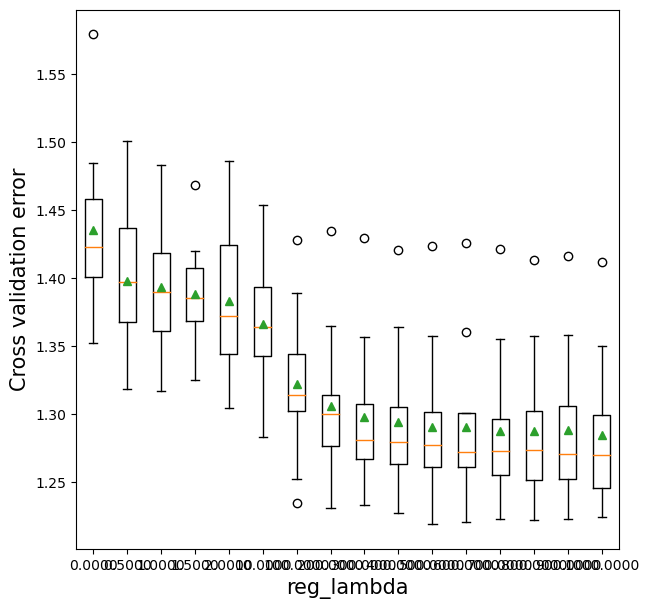

In [ ]:
def get_models():
    models = dict()
    # explore 'reg_lambda' from 0.1 to 2 in 0.1 increments
    for i in [0,0.5,1.0,1.5,2,10,100,200,300,400,500,600,700,800,900,1000]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(reg_lambda=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('reg_lambda',fontsize=15)

>0.0000 1.4 (0.0)
>10.0000 1.3 (0.1)
>100.0000 1.3 (0.1)
>1000.0000 1.4 (0.1)
>10000.0000 1.4 (0.1)
>100000.0000 1.4 (0.1)
>1000000.0000 1.4 (0.1)
>10000000.0000 1.4 (0.1)
>100000000.0000 1.4 (0.1)
>1000000000.0000 1.4 (0.1)


Text(0.5, 0, 'gamma')

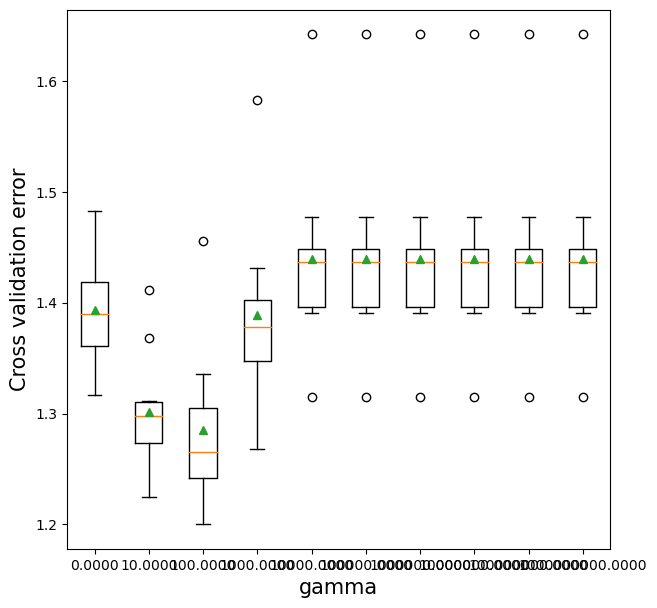

In [ ]:
def get_models():
    models = dict()
    # explore gamma from 0.1 to 2 in 0.1 increments
    for i in [0,10,1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(gamma=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('gamma',fontsize=15)

In [ ]:
xg_model = xgb.XGBRegressor(random_state=1, reg_lambda=700 ,gamma=100, n_estimators=14, 
                            learning_rate=0.05, max_depth=16).fit(X_train, y_train)

In [ ]:
#RMSE based on the optimal parameter values
np.sqrt(mean_squared_error(np.exp(xg_model.predict(X_test)),y_test))